In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Capstone project - HealthCare Fraud Detection : Random Forest Models

In [2]:
!pip install scikit-learn-intelex

In [3]:
from IPython import get_ipython
from IPython.display import display

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Add the directory containing LGR_helper.py to sys.path
import sys
import os

# Path to the directory containing LGR_helper.py on Google Drive
lgr_helper_dir = '/content/drive/MyDrive'

# Check if the directory exists before adding it to sys.path
if os.path.exists(lgr_helper_dir):
    sys.path.append(lgr_helper_dir)
    print(f"Added '{lgr_helper_dir}' to sys.path.")
else:
    print(f"Warning: The directory '{lgr_helper_dir}' does not exist. Please check the path.")

# Import necessary libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,\
StratifiedKFold, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# Import RocCurveDisplay instead of the deprecated plot_roc_curve
from sklearn.metrics import confusion_matrix, roc_auc_score,f1_score, RocCurveDisplay
from sklearn.metrics import classification_report as cl_rep_skl
from yellowbrick.classifier import confusion_matrix, classification_report, ROCAUC
from yellowbrick.model_selection import CVScores

# Import from your custom helper modules
try:
    from cp_clean_helper import show_values
    print("Successfully imported cp_clean_helper.")
except ModuleNotFoundError:
     print("Warning: cp_clean_helper.py not found. Please ensure its directory is in sys.path.")

try:
    from LGR_helper import std_num_cols, rb_scale_cols, model_results, get_confusion_matrix
    print("Successfully imported LGR_helper.")
except ModuleNotFoundError:
    print("Error: LGR_helper.py not found in the specified directory.")
    print("Please ensure the file is located at '/content/drive/MyDrive/LGR_helper.py'")


from sklearn import tree
import graphviz as gv
from IPython.display import display
from IPython.display import SVG
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

# Loading datasets

# Assuming your data files are also in Google Drive root directory
# Adjust the paths if needed
train_df = pd.read_csv("/content/drive/MyDrive/clean_train.csv",index_col=0)
test_df = pd.read_csv("/content/drive/MyDrive/clean_test.csv",index_col=0)

# Dropping some ID related features and created new model dfs

traindf = train_df.drop(['BeneID','ClaimID','Provider'], axis=1)
testdf = test_df.drop(['BeneID','ClaimID','Provider'], axis=1)

# Looking at dataset shapes

print('Shape of original train data :',train_df.shape)
print('Shape of original test data :',test_df.shape)
print('Shape of model train data :',traindf.shape)
print('Shape of model test data :',testdf.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Added '/content/drive/MyDrive' to sys.path.


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Successfully imported cp_clean_helper.
Successfully imported LGR_helper.
Shape of original train data : (558211, 61)
Shape of original test data : (135392, 60)
Shape of model train data : (558211, 58)
Shape of model test data : (135392, 57)


# Loading datasets, dropping few columns, and looking at shapes:-

In [4]:
# Loading datasets

train_df = pd.read_csv("/content/drive/MyDrive/clean_train.csv",index_col=0)
test_df = pd.read_csv("/content/drive/MyDrive/clean_test.csv",index_col=0)

# Dropping some ID related features and created new model dfs

traindf = train_df.drop(['BeneID','ClaimID','Provider'], axis=1)
testdf = test_df.drop(['BeneID','ClaimID','Provider'], axis=1)

# Looking at dataset shapes

print('Shape of original train data :',train_df.shape)
print('Shape of original test data :',test_df.shape)
print('Shape of model train data :',traindf.shape)
print('Shape of model test data :',testdf.shape)

Shape of original train data : (558211, 61)
Shape of original test data : (135392, 60)
Shape of model train data : (558211, 58)
Shape of model test data : (135392, 57)


# # Train-Test split:


In [5]:
# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(traindf.drop('PotentialFraud', axis=1), traindf['PotentialFraud'], random_state=42,\
                                                shuffle=True, stratify=traindf['PotentialFraud'], test_size=0.3)

# Looking at dataset shapes

print('\n')
print('Shape of imbalanced trainX data :',trainX.shape)
print('Shape of imbalanced trainY data :',trainY.shape)
print('Shape of imbalanced testX data :',testX.shape)
print('Shape of imbalanced testY data :',testY.shape)
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Fraud/Non-Fraud (trainY) :',trainY.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY) :',testY.value_counts(normalize=True)*100)
print('\n')
print("*"*60)



Shape of imbalanced trainX data : (390747, 57)
Shape of imbalanced trainY data : (390747,)
Shape of imbalanced testX data : (167464, 57)
Shape of imbalanced testY data : (167464,)


************************************************************


Class ratio - Fraud/Non-Fraud (trainY) : PotentialFraud
No     61.878914
Yes    38.121086
Name: proportion, dtype: float64
Class ratio - Fraud/Non-Fraud (testY) : PotentialFraud
No     61.878971
Yes    38.121029
Name: proportion, dtype: float64


************************************************************


In [6]:
# Dropping some additional features to evaluate performance

trainX = trainX.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','ChronicCond_Alzheimer',\
                            'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',\
                            'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',\
                            'ChronicCond_Depression', 'ChronicCond_Diabetes',\
                            'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',\
                            'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'], axis=1)

testX = testX.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','ChronicCond_Alzheimer',\
                          'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',\
                          'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',\
                          'ChronicCond_Depression', 'ChronicCond_Diabetes',\
                          'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',\
                          'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'], axis=1)

# # SMOTE Upsampling:

In [7]:
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE, BorderlineSMOTE

In [8]:
# Upsampling the minority class via SMOTE

trainX_SM, trainY_SM = SMOTE(random_state=0, k_neighbors=7).fit_resample(trainX, trainY)
testX_SM, testY_SM = SMOTE(random_state=0, k_neighbors=7).fit_resample(testX, testY)

# Upsampling the minority class via Borderline SMOTE

trainX_BSM, trainY_BSM = BorderlineSMOTE(random_state=0).fit_resample(trainX, trainY)
testX_BSM, testY_BSM = BorderlineSMOTE(random_state=0).fit_resample(testX, testY)

# Looking at dataset shapes

print('\n')
print('Shape of SMOTE balanced trainX data :',trainX_SM.shape)
print('Shape of SMOTE balanced trainY data :',trainY_SM.shape)
print('Shape of SMOTE balanced testX data :',testX_SM.shape)
print('Shape of SMOTE balanced testY data :',testY_SM.shape)
print('Shape of Borderline SMOTE balanced trainX data :',trainX_BSM.shape)
print('Shape of Borderline SMOTE balanced trainY data :',trainY_BSM.shape)
print('Shape of Borderline SMOTE balanced testX data :',testX_BSM.shape)
print('Shape of Borderline SMOTE balanced testY data :',testY_BSM.shape, end='\n')
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Fraud/Non-Fraud (trainY_SM) :',trainY_SM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY_SM) :',testY_SM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (trainY_BSM) :',trainY_BSM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY_BSM) :',testY_BSM.value_counts(normalize=True)*100, end='\n')
print('\n')
print("*"*60)



Shape of SMOTE balanced trainX data : (483580, 44)
Shape of SMOTE balanced trainY data : (483580,)
Shape of SMOTE balanced testX data : (207250, 44)
Shape of SMOTE balanced testY data : (207250,)
Shape of Borderline SMOTE balanced trainX data : (483580, 44)
Shape of Borderline SMOTE balanced trainY data : (483580,)
Shape of Borderline SMOTE balanced testX data : (207250, 44)
Shape of Borderline SMOTE balanced testY data : (207250,)


************************************************************


Class ratio - Fraud/Non-Fraud (trainY_SM) : PotentialFraud
Yes    50.0
No     50.0
Name: proportion, dtype: float64
Class ratio - Fraud/Non-Fraud (testY_SM) : PotentialFraud
Yes    50.0
No     50.0
Name: proportion, dtype: float64
Class ratio - Fraud/Non-Fraud (trainY_BSM) : PotentialFraud
Yes    50.0
No     50.0
Name: proportion, dtype: float64
Class ratio - Fraud/Non-Fraud (testY_BSM) : PotentialFraud
Yes    50.0
No     50.0
Name: proportion, dtype: float64


*******************************

### # Robust Scaling the train/test features for  balanced datasets:

In [9]:
# SMOTE balanced dataset

rb_scale_cols(trainX_SM)
rb_scale_cols(testX_SM)

# BorderlineSMOTE balanced dataset

rb_scale_cols(trainX_BSM)
rb_scale_cols(testX_BSM)

### # Working towards the final models

converted  target values into numbers:

In [10]:
trainY_SM = trainY_SM.map({'No': 0, 'Yes': 1})
testY_SM = testY_SM.map({'No': 0, 'Yes': 1})


In [11]:
# Then proceed to the model training and evaluation:
rf5_sm = RandomForestClassifier(oob_score=True, random_state=42, max_depth=25)
model_results(trainX_SM, trainY_SM, testX_SM, testY_SM, rf5_sm, show=True)

The Model Results for  RandomForestClassifier(max_depth=25, oob_score=True, random_state=42)
************************************************************
Train Accuracy is equal to 0.915
Test Accuracy is equal to 0.718
The Precision score is 0.743
The Average Precision score is 0.662
The Recall score is 0.668
The F1 score is 0.703
The AUC/ROC score is 0.718
True-Positive: 69177.000
True-Negative: 79676.000
False-Positive: 23949.000
False-Negative: 34448.000
Correctly Classified: 148853.000
Incorrectly Classified: 58397.000


[0.9154721038918069,
 0.7182291917973462,
 0.7428322917337801,
 0.6675705669481303]

In [12]:
trainY_BSM = trainY_BSM.map({'No': 0, 'Yes': 1})
testY_BSM = testY_BSM.map({'No': 0, 'Yes': 1})

In [13]:
# Stump model:

rf5_bsm = RandomForestClassifier(oob_score=True, random_state=42, max_depth=25)

# Model with all features and BSM:

model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, rf5_bsm, show=True)

The Model Results for  RandomForestClassifier(max_depth=25, oob_score=True, random_state=42)
************************************************************
Train Accuracy is equal to 0.916
Test Accuracy is equal to 0.712
The Precision score is 0.733
The Average Precision score is 0.655
The Recall score is 0.666
The F1 score is 0.698
The AUC/ROC score is 0.712
True-Positive: 69061.000
True-Negative: 78490.000
False-Positive: 25135.000
False-Negative: 34564.000
Correctly Classified: 147551.000
Incorrectly Classified: 59699.000


[0.9156437404359155,
 0.7119469240048251,
 0.7331627669964754,
 0.6664511459589867]

In [14]:
# Selecting the best model from the Grid Search as the final SM model with some changes

fin_rf1 = RandomForestClassifier(oob_score=True, random_state=42, max_depth=35,\
                                min_samples_leaf=1, min_samples_split=11, n_estimators=115)

# Model with all features and BSM:

model_results(trainX_SM, trainY_SM, testX_SM, testY_SM, fin_rf1, show=True)

The Model Results for  RandomForestClassifier(max_depth=35, min_samples_split=11, n_estimators=115,
                       oob_score=True, random_state=42)
************************************************************
Train Accuracy is equal to 0.979
Test Accuracy is equal to 0.740
The Precision score is 0.775
The Average Precision score is 0.686
The Recall score is 0.676
The F1 score is 0.722
The AUC/ROC score is 0.740
True-Positive: 70037.000
True-Negative: 83296.000
False-Positive: 20329.000
False-Negative: 33588.000
Correctly Classified: 153333.000
Incorrectly Classified: 53917.000


[0.9786819140576534,
 0.7398455971049457,
 0.7750370714649315,
 0.6758697225572979]

In [15]:
# Selecting the best model from the Grid Search as the final BSM model with some changes

fin_rf2 = RandomForestClassifier(oob_score=True, random_state=42, max_depth=35,\
                                 min_samples_leaf=3, min_samples_split=6, n_estimators=125)

# Model with all features and BSM:

model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, fin_rf2, show=True)

The Model Results for  RandomForestClassifier(max_depth=35, min_samples_leaf=3, min_samples_split=6,
                       n_estimators=125, oob_score=True, random_state=42)
************************************************************
Train Accuracy is equal to 0.981
Test Accuracy is equal to 0.736
The Precision score is 0.767
The Average Precision score is 0.681
The Recall score is 0.679
The F1 score is 0.720
The AUC/ROC score is 0.736
True-Positive: 70326.000
True-Negative: 82204.000
False-Positive: 21421.000
False-Negative: 33299.000
Correctly Classified: 152530.000
Incorrectly Classified: 54720.000


[0.9805451011208073,
 0.7359710494571773,
 0.7665209761627083,
 0.6786586248492159]

### # Feature Selection with RFE

In [16]:
from sklearn.feature_selection import RFE

# Extracting top 20 best features with RFE:

rfe1 = RFE(estimator=fin_rf1, n_features_to_select=20, step=10)

# Running model to compare performance

model_results(trainX_SM, trainY_SM, testX_SM, testY_SM, rfe1, show=True)

The Model Results for  RFE(estimator=RandomForestClassifier(max_depth=35, min_samples_split=11,
                                     n_estimators=115, oob_score=True,
                                     random_state=42),
    n_features_to_select=20, step=10)
************************************************************
Train Accuracy is equal to 0.987
Test Accuracy is equal to 0.766
The Precision score is 0.801
The Average Precision score is 0.713
The Recall score is 0.707
The F1 score is 0.751
The AUC/ROC score is 0.766
True-Positive: 73266.000
True-Negative: 85479.000
False-Positive: 18146.000
False-Negative: 30359.000
Correctly Classified: 158745.000
Incorrectly Classified: 48505.000


[0.9866226891103851, 0.7659589867310012, 0.801492145451363, 0.7070301568154402]

In [17]:
# Looking at RFE feature selection

print(trainX_SM.columns[rfe1.support_])

Index(['State', 'County', 'Age', 'Tot_Reimbursed_Amt', 'Tot_Deductible_Amt',
       'DOB_year', 'DOB_month', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmAdmitDiagnosisCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'Claim_Start_Month', 'Insurance_Covered_Per',
       'Total_Claim_Amt', 'Chr_Cond_Count'],
      dtype='object')


In [18]:
# Extracting top 20 best features with RFE:

rfe2 = RFE(estimator=fin_rf2, n_features_to_select=20, step=10)

# Running model to compare performance

model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, rfe2, show=True)

The Model Results for  RFE(estimator=RandomForestClassifier(max_depth=35, min_samples_leaf=3,
                                     min_samples_split=6, n_estimators=125,
                                     oob_score=True, random_state=42),
    n_features_to_select=20, step=10)
************************************************************
Train Accuracy is equal to 0.987
Test Accuracy is equal to 0.761
The Precision score is 0.791
The Average Precision score is 0.707
The Recall score is 0.709
The F1 score is 0.748
The AUC/ROC score is 0.761
True-Positive: 73514.000
True-Negative: 84259.000
False-Positive: 19366.000
False-Negative: 30111.000
Correctly Classified: 157773.000
Incorrectly Classified: 49477.000


[0.986504818230696, 0.7612689987937273, 0.7914944013781223, 0.7094234016887817]

In [19]:
# Looking at RFE feature selection

print(trainX_BSM.columns[rfe2.support_])

Index(['State', 'County', 'Age', 'Tot_Reimbursed_Amt', 'Tot_Deductible_Amt',
       'DOB_year', 'DOB_month', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmAdmitDiagnosisCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'Claim_Start_Month', 'Insurance_Covered_Per',
       'Total_Claim_Amt', 'Chr_Cond_Count'],
      dtype='object')


### # Feature Selection with SelectKBest

In [20]:
from sklearn.feature_selection import SelectKBest

# Extracting top 20 best features by applying SelectKBest class

bestfeatures1 = SelectKBest(k=20)
fit1 = bestfeatures1.fit(trainX_SM, trainY_SM)
dfscores = pd.DataFrame(fit1.scores_)
dfcolumns = pd.DataFrame(trainX_SM.columns)

#concat two dataframes

featureScores1 = pd.concat([dfcolumns,dfscores],axis=1)
featureScores1.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores1.nlargest(20,'Score'))  #printing 10 best features

                  Features        Score
17       DeductibleAmtPaid  5867.520417
18      DiagnosisGroupCode  4947.267627
0                   Gender  4260.034986
34           Hospital_Stay  3438.865976
39         Total_Claim_Amt  3236.504273
12  InscClaimAmtReimbursed  2937.077454
29      ClmProcedureCode_1  2352.288924
27      ClmDiagnosisCode_9  1921.833633
26      ClmDiagnosisCode_8  1894.904913
2    RenalDiseaseIndicator  1785.724016
25      ClmDiagnosisCode_7  1721.845340
24      ClmDiagnosisCode_6  1396.983950
3                    State  1335.522541
43          Chr_Cond_Count  1208.187309
23      ClmDiagnosisCode_5  1126.867406
30      ClmProcedureCode_2   813.158557
16   ClmAdmitDiagnosisCode   770.057906
22      ClmDiagnosisCode_4   651.887687
7       Tot_Reimbursed_Amt   497.878115
37       Claim_Start_Month   382.678498


In [21]:
from sklearn.feature_selection import SelectKBest

# Extracting top 20 best features by applying SelectKBest class

bestfeatures2 = SelectKBest(k=20)
fit2 = bestfeatures2.fit(trainX_BSM, trainY_BSM)
dfscores = pd.DataFrame(fit2.scores_)
dfcolumns = pd.DataFrame(trainX_BSM.columns)

#concat two dataframes

featureScores2 = pd.concat([dfcolumns,dfscores],axis=1)
featureScores2.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores2.nlargest(20,'Score'))  #printing 10 best features

                  Features        Score
0                   Gender  4155.367117
17       DeductibleAmtPaid  3143.514624
18      DiagnosisGroupCode  2616.581556
34           Hospital_Stay  1831.444690
2    RenalDiseaseIndicator  1776.854552
39         Total_Claim_Amt  1646.432963
12  InscClaimAmtReimbursed  1481.391703
29      ClmProcedureCode_1  1242.842004
43          Chr_Cond_Count  1190.657100
3                    State   942.408093
27      ClmDiagnosisCode_9   866.579043
26      ClmDiagnosisCode_8   865.828705
25      ClmDiagnosisCode_7   781.247777
24      ClmDiagnosisCode_6   570.252578
23      ClmDiagnosisCode_5   461.329510
30      ClmProcedureCode_2   439.161461
37       Claim_Start_Month   433.789779
16   ClmAdmitDiagnosisCode   422.414040
42          Hospital_Count   389.001931
10               DOB_month   376.744869


In [22]:
tot_df = pd.concat([featureScores1,featureScores2],axis=0)
tot_df = pd.DataFrame(tot_df.groupby('Features')['Score'].mean()\
                      .sort_values(ascending=False)).reset_index().head(10)

Text(0.5, 1.0, 'SelectKBest Feature Importance Scores \n')

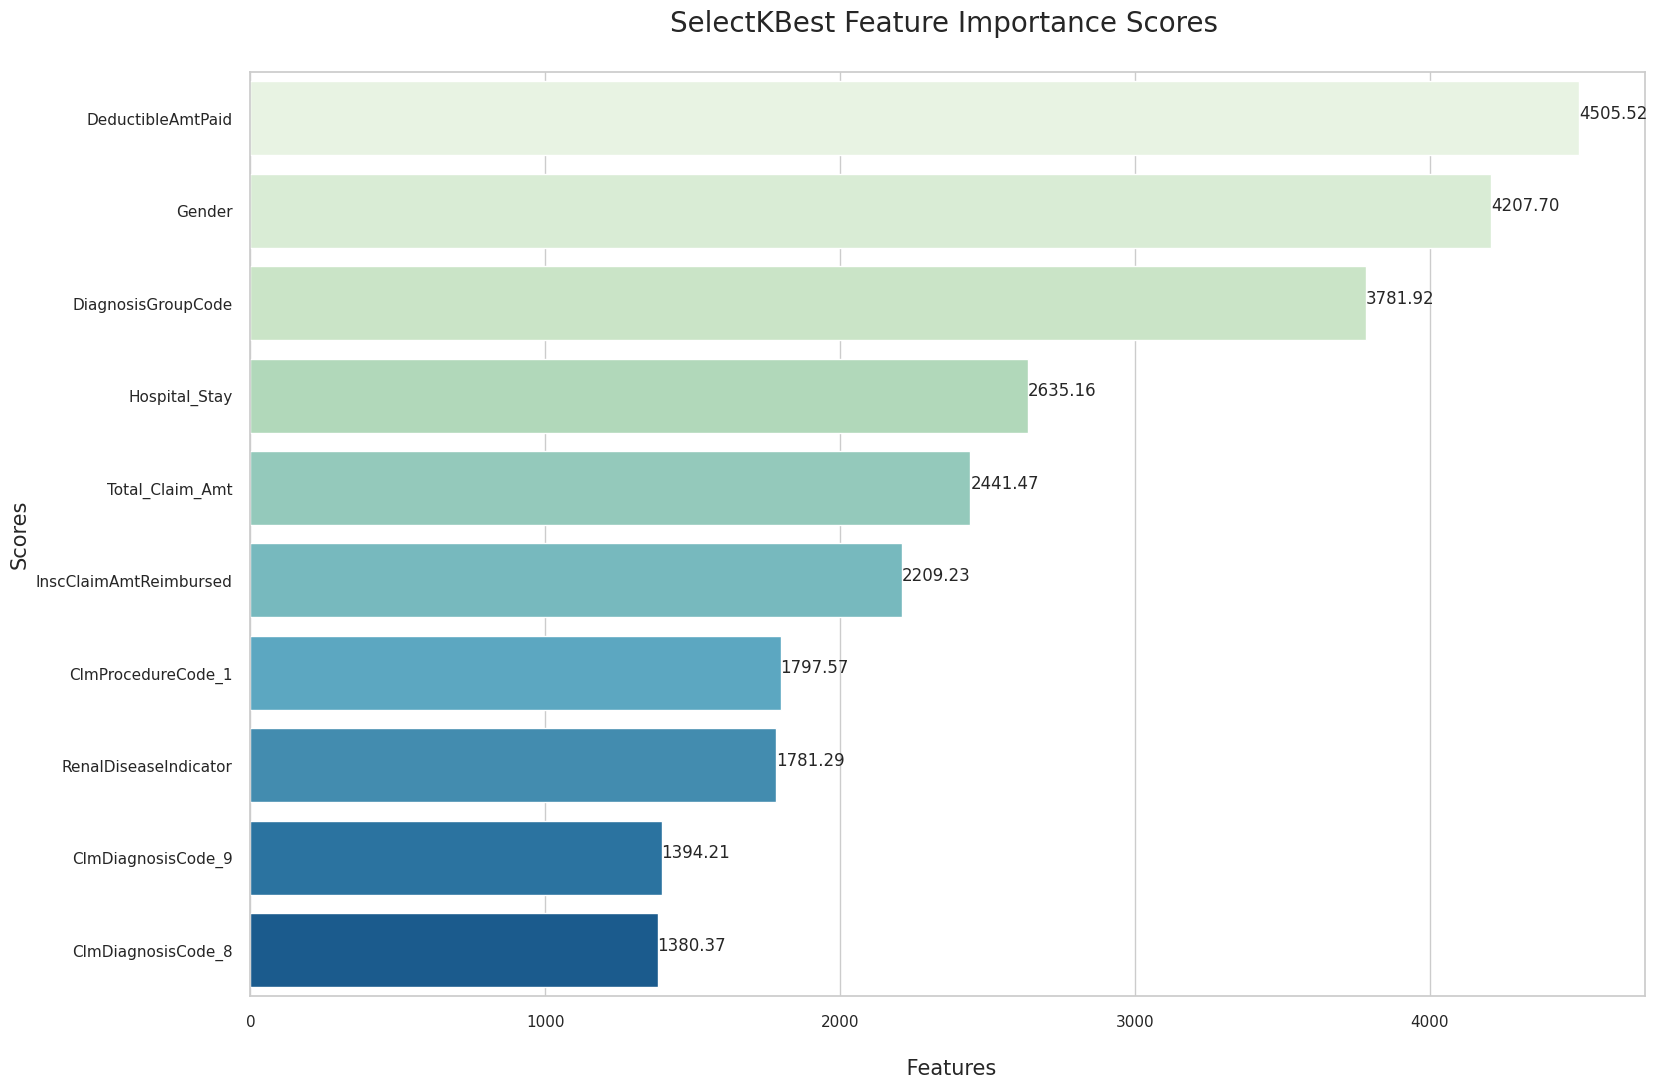

In [23]:
# Plotting the results

plt.figure(figsize=(18,12))
sns.set_theme(style='whitegrid')
splot = sns.barplot(data=tot_df, y='Features', x='Score', palette="GnBu")
show_values(splot, "h", space=0)
plt.xlabel("\n Features", fontsize = 15)
plt.ylabel("Scores", fontsize = 15)
plt.title("SelectKBest Feature Importance Scores \n", fontsize = 20)

### # Random Forest Feature Importances using RFE support features:

In [24]:
# Model using RFE 20 features

selected_feat1 = trainX_SM.columns[rfe1.support_]

model_results(trainX_SM[selected_feat1], trainY_SM, testX_SM[selected_feat1], testY_SM, fin_rf1, show=True)

The Model Results for  RandomForestClassifier(max_depth=35, min_samples_split=11, n_estimators=115,
                       oob_score=True, random_state=42)
************************************************************
Train Accuracy is equal to 0.987
Test Accuracy is equal to 0.766
The Precision score is 0.801
The Average Precision score is 0.713
The Recall score is 0.707
The F1 score is 0.751
The AUC/ROC score is 0.766
True-Positive: 73266.000
True-Negative: 85479.000
False-Positive: 18146.000
False-Negative: 30359.000
Correctly Classified: 158745.000
Incorrectly Classified: 48505.000


[0.9866226891103851, 0.7659589867310012, 0.801492145451363, 0.7070301568154402]

In [25]:
# Model using RFE 20 features

selected_feat2 = trainX_BSM.columns[rfe2.support_]

model_results(trainX_BSM[selected_feat2], trainY_BSM, testX_BSM[selected_feat2], testY_BSM, fin_rf2, show=True)

The Model Results for  RandomForestClassifier(max_depth=35, min_samples_leaf=3, min_samples_split=6,
                       n_estimators=125, oob_score=True, random_state=42)
************************************************************
Train Accuracy is equal to 0.987
Test Accuracy is equal to 0.761
The Precision score is 0.791
The Average Precision score is 0.707
The Recall score is 0.709
The F1 score is 0.748
The AUC/ROC score is 0.761
True-Positive: 73514.000
True-Negative: 84259.000
False-Positive: 19366.000
False-Negative: 30111.000
Correctly Classified: 157773.000
Incorrectly Classified: 49477.000


[0.986504818230696, 0.7612689987937273, 0.7914944013781223, 0.7094234016887817]

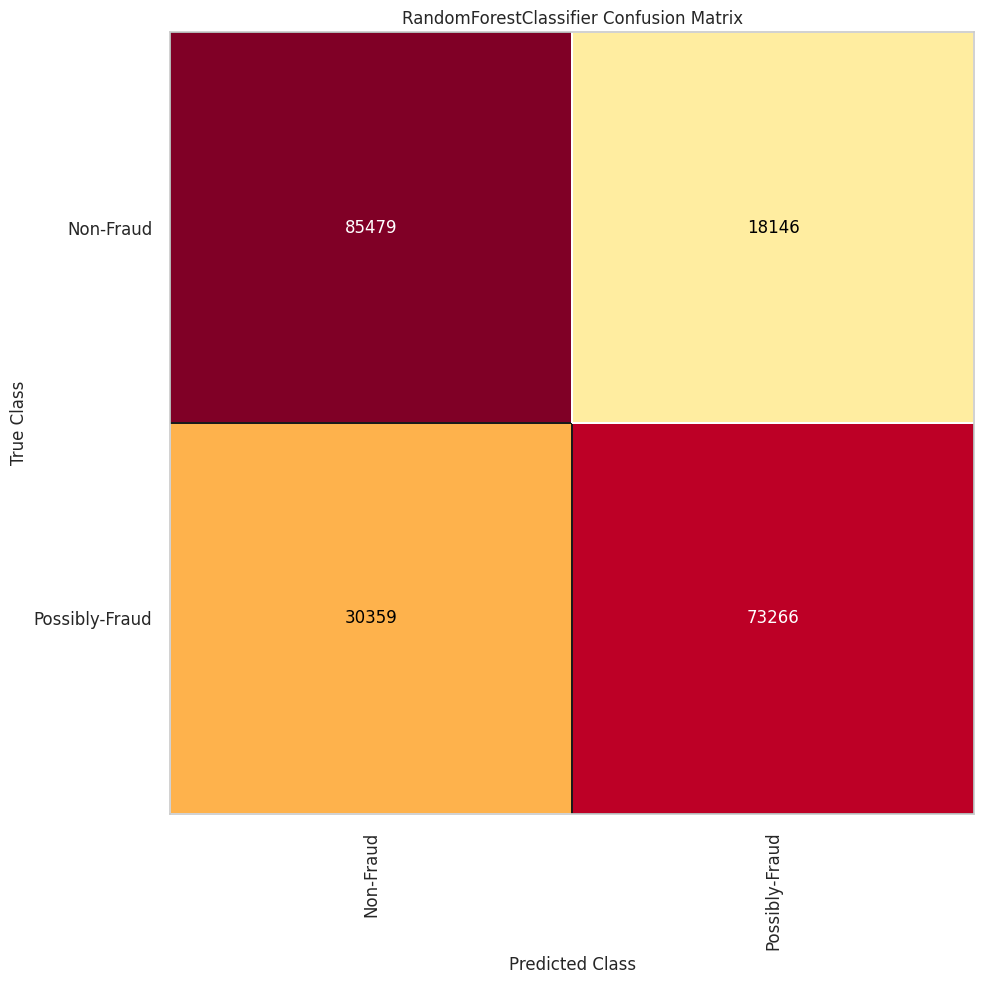

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [26]:
# Visualizing the confusion matrix with Yellowbricks (thres=0.5)

plt.figure(figsize = (10,10))
visualizer = confusion_matrix(
    fin_rf1,
    trainX_SM[selected_feat1], trainY_SM, testX_SM[selected_feat1], testY_SM,
    classes=['Non-Fraud', 'Possibly-Fraud'])

visualizer.show()

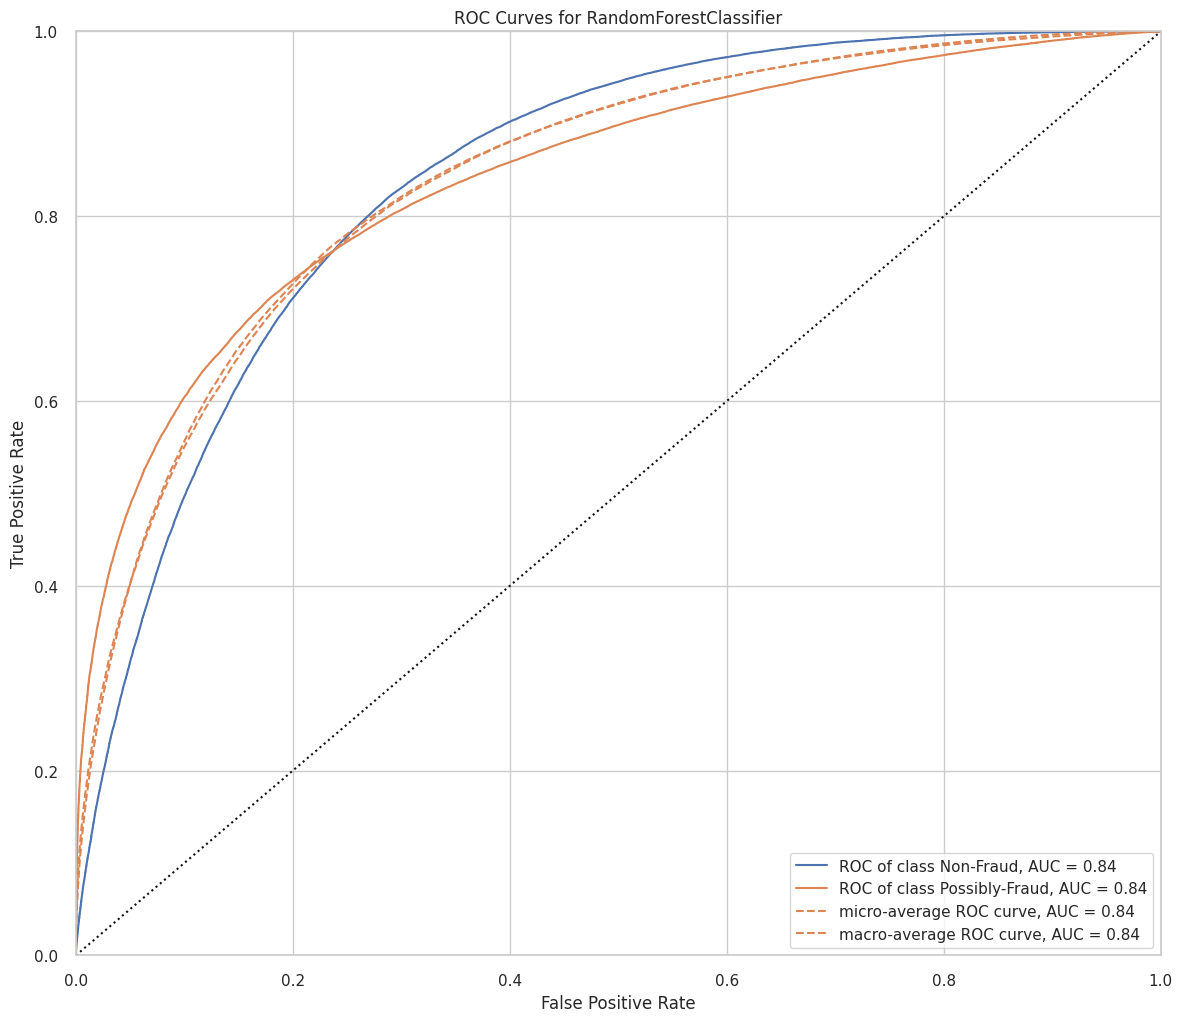

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [27]:
# Visualizing the AUC/ROC curve with Yellowbricks

plt.figure(figsize = (14,12))
sns.set_style("whitegrid")

visualizer = ROCAUC(fin_rf1, classes=['Non-Fraud', 'Possibly-Fraud'])

visualizer.fit(trainX_SM[selected_feat1], trainY_SM)        # Fit the training data to the visualizer
visualizer.score(testX_SM[selected_feat1], testY_SM)        # Evaluate the model on the test data

visualizer.show()

### # Threshold selection

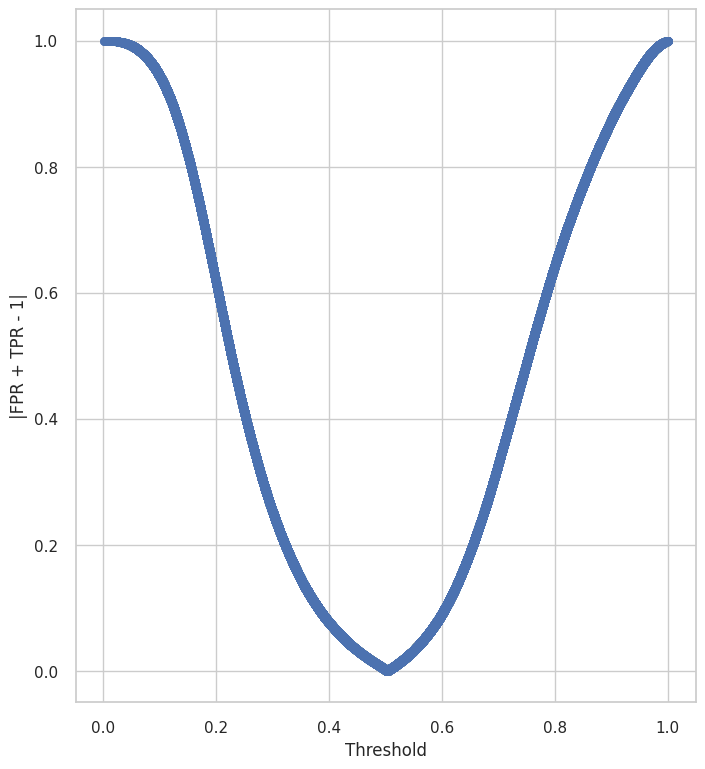

In [30]:
# Visualizing the threshold

from sklearn.metrics import roc_curve

sns.set_style("whitegrid")
fpr1, tpr1, thresholds1 = roc_curve(trainY_SM,fin_rf1.predict_proba(trainX_SM[selected_feat1])[:,1],drop_intermediate=False)

plt.figure(figsize = (8,9))
plt.scatter(thresholds1,np.abs(fpr1+tpr1-1),linewidths=0.3)
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [31]:
thresholds1[np.argmin(np.abs(fpr1+tpr1-1))]

np.float64(0.5030492745638012)

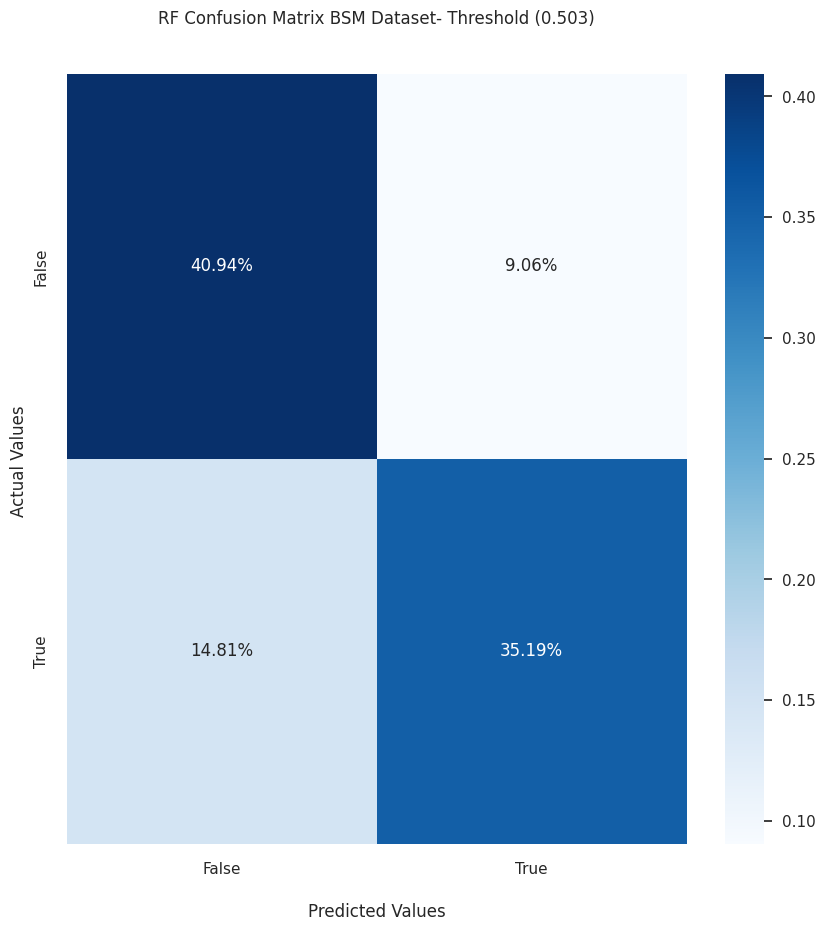

In [32]:
# Looking at confusion matrix (thres=0.503)

cm2 = get_confusion_matrix(fin_rf2, testX_BSM[selected_feat2], testY_BSM, thres=0.503)

#Plotting the confusion matrix

labels = ['Non-Fraud', 'Possibly-Fraud']

plt.figure(figsize = (10,10))

ax = sns.heatmap(cm2/np.sum(cm2), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('RF Confusion Matrix BSM Dataset- Threshold (0.503)\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()